# Figure 5- V2 Animals Have Cleaner Poking Habits


In [1]:
import utils as u
import config as c
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp
from scipy.stats import ttest_ind

sns.set_context("talk")
%load_ext autoreload
%autoreload 2

# Libraries


# Data Load


In [2]:
pdf = u.load_poke_df()

Loading poke data from directory: /Users/jessbreda/Desktop/github/jbreda_animal_training/notebooks/fixation_publication


# Utility Functions


In [26]:
"""Histogram Plots"""


def plot_relative_cpoke_dur_histplot(
    df,
    ax=None,
    xmin=-2.5,
    xmax=2,
    palette=c.VALID_PALETTE,
    ylim=None,
    title=None,
    title_color="k",
    **kwargs,
):
    """
    plot histogram of cpoke timing relative to the go cue for all failed and
    valid cpokes (including settling_in cpokes)

    params
    ------
    df : pd.DataFrame
        dataframe with columns `relative_cpoke_dur`and `was_valid`
        with cpoke as row index
    ax : matplotlib.axes (optional, default = None)
        axis to plot to
    xmin : float (optional, default = -2.5)
        minimum x-axis value to plot
    xmax : float (optional, default = 2)
        maximum x-axis value to plot
    ylim : tuple (optional, default = None)
        y-axis limits to plot
    title : str (optional, default = None)
        title of the plot
    title_color : str (optional, default = "k")
        color of the title
    """

    if xmin:
        df = df.query("relative_cpoke_dur > @xmin")
    if xmax:
        df = df.query("relative_cpoke_dur < @xmax")

    if ax is None:
        fig, ax = plt.subplots(figsize=(10, 4))
    ax.axvspan(0, 0.2, color='gray', alpha=0.25, label="Go Cue")

    sns.histplot(
        data=df,
        x="relative_cpoke_dur",
        hue="was_valid",
        hue_order=[False, True],
        ax=ax,
        palette=palette,
        binwidth=0.025,
        **kwargs,
    )

    # plot vertical lines

    avg_failed_dur = df.query("was_valid == False").relative_cpoke_dur.mean()
    ax.axvline(avg_failed_dur, color=palette[0], lw=3, label="Mean Violation")
    print("Violation Duration Stats")
    std = df.query("was_valid == False").relative_cpoke_dur.std()
    print(f"N violation cpokes: {df.query('was_valid == False').shape[0]}")
    print(f"Mean Violation Duration: {avg_failed_dur:.2f} +/- {std:.2f} std")
    print(
        f"Median Violation Duration: {df.query('was_valid == False').relative_cpoke_dur.median():.2f}"
    )
    median_failed_dur = df.query("was_valid == False").relative_cpoke_dur.median()
    ax.axvline(
        median_failed_dur,
        color=palette[0],
        lw=3,
        ls="--",
        label="Median Violation",
    )

    avg_valid_dur = df.query("was_valid == True").relative_cpoke_dur.mean()
    ax.axvline(avg_valid_dur, color=palette[1], lw=3, label="Mean Valid ")
    print("\nValid Duration Stats")
    std = df.query("was_valid == True").relative_cpoke_dur.std()
    print(f"N valid cpokes: {df.query('was_valid == True').shape[0]}")
    print(f"Mean Valid Duration: {avg_valid_dur:.2f} +/- {std:.2f} std")
    print(
        f"Median Valid Duration: {df.query('was_valid == True').relative_cpoke_dur.median():.2f}"
    )
    median_valid_dur = df.query("was_valid == True").relative_cpoke_dur.median()
    ax.axvline(median_valid_dur, color=palette[1], lw=3, ls="--", label="Median Valid")

    ax.axvline(0, color="k")
    if title is None:
        failure_rate = df.query("was_valid == False").shape[0] / df.shape[0]
        title = f"Failure_rate {failure_rate:.2f},  Avg Cpoke Dur: {df.cpoke_dur.mean():.2f}"

    ax.legend(title="", loc="upper left", frameon=False)

    # aesthetics
    _ = ax.set(
        xlabel="Cpoke Fixation Duration Relative to Go-Cue [s]",
        ylim=(0, ylim),
        xlim=(xmin, xmax),
    )
    ax.set_title(title, color=title_color, fontweight="bold")
    plt.tight_layout()

    sns.despine()

    return fig, ax

In [44]:
"""KS Stats & Empirical CDFs"""


def plot_ecdfs(data1, data2, label1, label2, title=None, palette=c.EXP_PALETTE):
    """
    Plot step-based empirical CDFs for two data arrays, highlighting the maximum
    vertical difference (KS distance) as a black arrow.
    """
    # Sort the data
    data1_sorted = np.sort(data1)
    data2_sorted = np.sort(data2)

    # Compute empirical CDF values
    cdf1 = np.arange(1, len(data1_sorted) + 1) / len(data1_sorted)
    cdf2 = np.arange(1, len(data2_sorted) + 1) / len(data2_sorted)

    # Create the plot
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.step(data1_sorted, cdf1, where="post", label=label1, color=palette[0])
    plt.step(data2_sorted, cdf2, where="post", label=label2, color=palette[1])

    # -------------------------------------------------------------------------
    # 1) Merge the sorted data, compute the two CDFs at each point in 'combined'
    # -------------------------------------------------------------------------
    combined = np.concatenate([data1_sorted, data2_sorted])
    combined.sort()

    cdf1_interp = np.searchsorted(data1_sorted, combined, side="right") / len(
        data1_sorted
    )
    cdf2_interp = np.searchsorted(data2_sorted, combined, side="right") / len(
        data2_sorted
    )

    # Find the maximum vertical difference
    diffs = np.abs(cdf1_interp - cdf2_interp)
    max_diff_idx = np.argmax(diffs)

    # Coordinates for the maximum difference
    max_diff_x = combined[max_diff_idx]
    max_diff_y1 = cdf1_interp[max_diff_idx]
    max_diff_y2 = cdf2_interp[max_diff_idx]

    # -------------------------------------------------------------------------
    # 2) Plot an arrow to illustrate the maximum vertical difference
    # -------------------------------------------------------------------------
    ylow, yhigh = sorted([max_diff_y1, max_diff_y2])

    # Arrow from ylow to yhigh at x = max_diff_x
    plt.annotate(
        "",
        xy=(max_diff_x, ylow),
        xytext=(max_diff_x, yhigh),
        arrowprops=dict(arrowstyle="<->", color="black", lw=2),
    )

    # Optionally, add a text label for the difference
    diff_value = yhigh - ylow
    plt.text(
        max_diff_x + 0.01,
        (ylow + yhigh) / 2,
        f"{diff_value:.3f}",
        color="black",
        va="center",
    )

    print(f"Maximum Difference at {max_diff_x:.3f}s")

    # -------------------------------------------------------------------------
    # 3) Finalize the plot
    # -------------------------------------------------------------------------
    plt.xlabel("Relative Cpoke Duration [s]")
    plt.ylabel("Empirical CDF")
    if title:
        plt.title(f"Empirical CDFs for {title}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    sns.despine()

    return fig, ax


def run_and_plot_ks_test(v1_data, v2_data, label1="V1", label2="V2", title=""):

    stat, pval = ks_2samp(v1_data, v2_data)
    if pval < 0.05:
        print(f"**SIGNIFICANT** {label1} and {label2} are different")
    print(f"{label1} KS statistic: {stat:.3f}, p-value: {pval:.3e}")

    # Plot
    fig, ax = plot_ecdfs(v1_data, v2_data, label1, label2, title)

    return fig, ax

In [28]:
"""Ttest Stats Over Days"""

def ttest_cpoke_durations_by_day(df, max_days):
    # Number of tests is the number of days
    number_of_tests = max_days
    # Dictionary to store t-test results for each day
    results = {}
    for day in range(1, max_days + 1):
        # Filter the data for the current day
        day_data = df[df["days_in_cpoke_growth"] == day]
        
        # Remove NaNs and split data into two groups based on experimental condition
        group_v1 = day_data[day_data["fix_experiment"] == "V1"]["relative_cpoke_dur"].dropna()
        group_v2 = day_data[day_data["fix_experiment"] == "V2"]["relative_cpoke_dur"].dropna()

        print(f"V1 size: {len(group_v1)}, V2 size: {len(group_v2)}")
        
        # Conduct independent t-test (use equal_var=False if variances are suspected to differ)
        t_stat, p_val = ttest_ind(group_v1, group_v2, equal_var=False)
        
        # Bonferroni adjustment: multiply by number of tests, capped at 1.0
        p_adj = min(p_val * number_of_tests, 1.0)
        
        # Store the results
        results[day] = {"t_stat": t_stat, "p_value": p_val, "p_adj": p_adj}
        
        # Print the results, highlighting if significant after adjustment
        signif_str = "**SIGNIFICANT**" if p_adj < 0.05 else ""
        print(f"Day {day}: {signif_str}\nt = {t_stat:.3f}, p = {p_val:.3e}, Bonferroni adj p = {p_adj:.3e}")
    
    return results

# A \* B (Histograms)


Violation Duration Stats
N violation cpokes: 16099
Mean Violation Duration: -0.50 +/- 0.45 std
Median Violation Duration: -0.36

Valid Duration Stats
N valid cpokes: 59823
Mean Valid Duration: 0.20 +/- 0.15 std
Median Valid Duration: 0.17


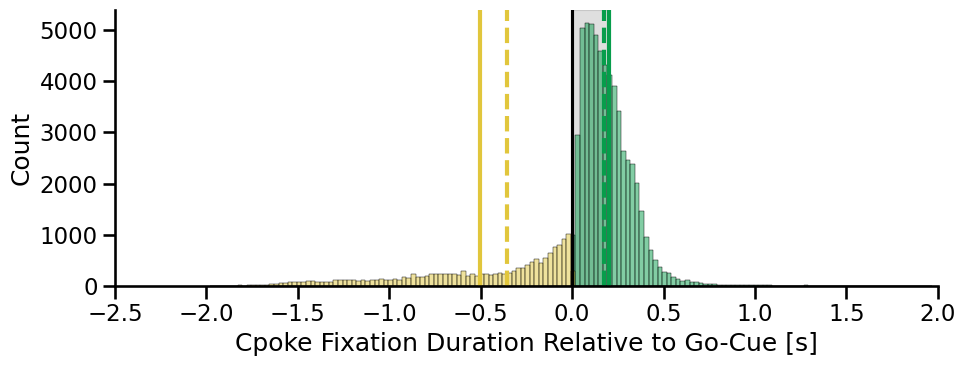

In [29]:
fig, ax = plot_relative_cpoke_dur_histplot(
    pdf.query("fix_experiment == 'V1' and stage in @c.GROWING_STAGES and fixation_dur < 2"),
    title="",
    title_color=c.V1_COLOR,
)

ax.legend().remove()
c.save_fig(fig, "fig5_V1_poke_histogram_growing_stages")

Violation Duration Stats
N violation cpokes: 19984
Mean Violation Duration: -0.80 +/- 0.56 std
Median Violation Duration: -0.72

Valid Duration Stats
N valid cpokes: 26807
Mean Valid Duration: 0.20 +/- 0.16 std
Median Valid Duration: 0.17


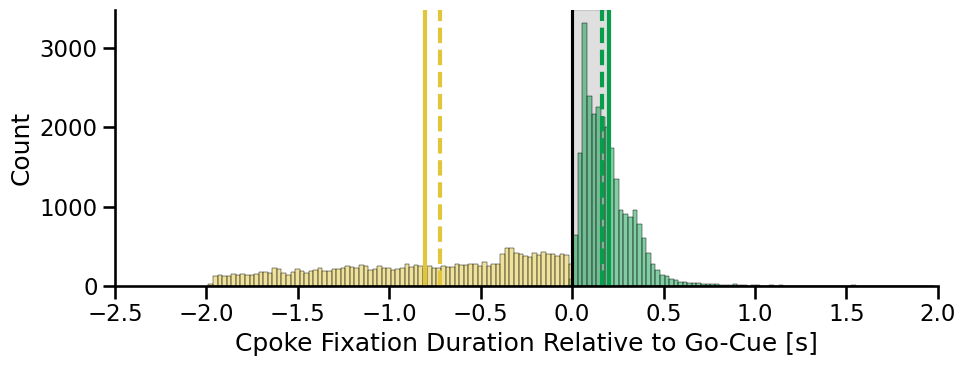

In [30]:
fig, ax = plot_relative_cpoke_dur_histplot(
    pdf.query("fix_experiment == 'V2' and stage in @c.GROWING_STAGES and fixation_dur < 2"),
    title="",
    title_color=c.V2_COLOR,
)

ax.legend().remove()
c.save_fig(fig, "fig5_V2_poke_histogram_growing_stages")

# C, D,E (Statistics for A & B, CDFs)


In [31]:
stats_df = pdf.query(
    "stage in @c.GROWING_STAGES and fixation_dur < 2 and relative_cpoke_dur < 1"
)  # only growth stages, les than 2s fixation and make sure we get rid of the extra long cpokes likley due to bpod error
stats_df = u.compute_days_relative_to_stage(stats_df.copy(), 5)
# Conditions V1
df_v1 = stats_df[stats_df["fix_experiment"] == "V1"]
all_v1 = df_v1["relative_cpoke_dur"].dropna()
valid_v1 = df_v1[df_v1["was_valid"] == True]["relative_cpoke_dur"].dropna()
invalid_v1 = df_v1[df_v1["was_valid"] == False]["relative_cpoke_dur"].dropna()
valid_v1_7_days = df_v1.query("days_relative_to_stage_5 <= 7 and was_valid == True")["relative_cpoke_dur"].dropna()
invalid_v1_7_days = df_v1.query("days_relative_to_stage_5 <= 7 and was_valid == False")["relative_cpoke_dur"].dropna()

# Conditions V2
df_v2 = stats_df[stats_df["fix_experiment"] == "V2"]
all_v2 = df_v2["relative_cpoke_dur"].dropna()

valid_v2 = df_v2[df_v2["was_valid"] == True]["relative_cpoke_dur"].dropna()
invalid_v2 = df_v2[df_v2["was_valid"] == False]["relative_cpoke_dur"].dropna()
valid_v2_7_days = df_v2.query("days_relative_to_stage_5 <= 7 and was_valid == True")["relative_cpoke_dur"].dropna()
invalid_v2_7_days = df_v2.query("days_relative_to_stage_5 <= 7 and was_valid == False")["relative_cpoke_dur"].dropna()


### All Trials


In [32]:
print(f"V1 size: {len(all_v1)}, V2 size: {len(all_v2)}")

V1 size: 75718, V2 size: 46636


**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.230, p-value: 0.000e+00
Maximum Difference at -0.128s


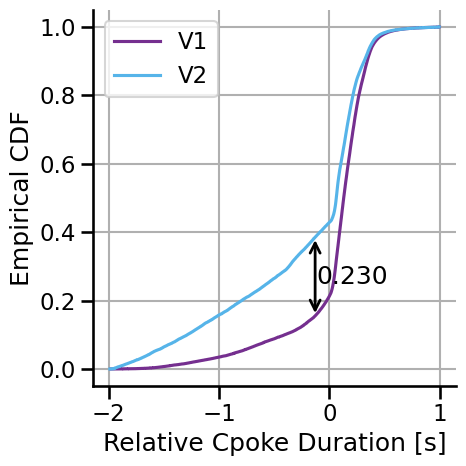

In [45]:
fig, ax = run_and_plot_ks_test(all_v1, all_v2, title="")
sns.despine(ax=ax)
c.save_fig(fig, "fig5_empirical_cdf_growing_pre_and_post_go")

### Violation Trials


In [46]:
print(f"V1 size: {len(invalid_v1)}, V2 size: {len(invalid_v2)}")

V1 size: 16099, V2 size: 19984


**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.222, p-value: 0.000e+00
Maximum Difference at -0.305s


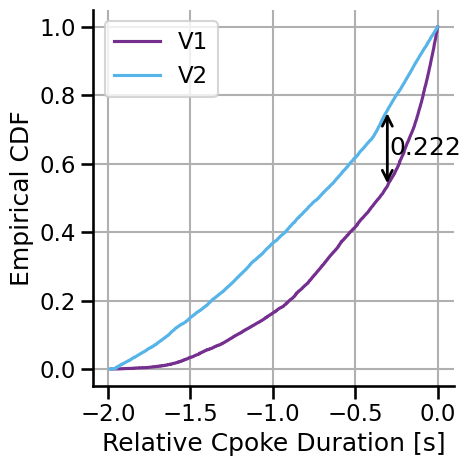

In [48]:
fig, ax = run_and_plot_ks_test(invalid_v1, invalid_v2, title="")

c.save_fig(fig, "fig5_empirical_cdf_growing_pre_go")

### Valid Trials


In [49]:
print(f"V1 size: {len(valid_v1)}, V2 size: {len(valid_v2)}")

V1 size: 59619, V2 size: 26652


**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.038, p-value: 4.059e-23
Maximum Difference at 0.223s


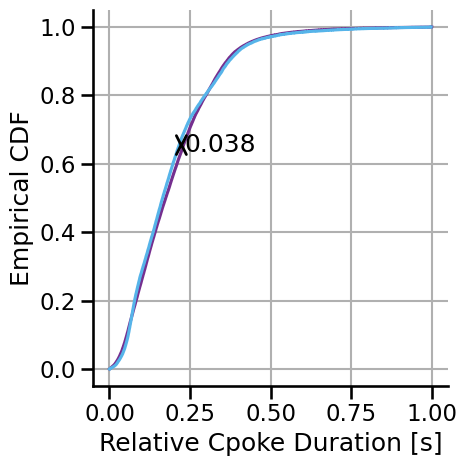

In [51]:
fig, ax = run_and_plot_ks_test(valid_v1, valid_v2, title="")

ax.legend().remove()
c.save_fig(fig, "fig5_empirical_cdf_growing_post_go")

### 7 days


**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.402, p-value: 0.000e+00
Maximum Difference at -0.271s


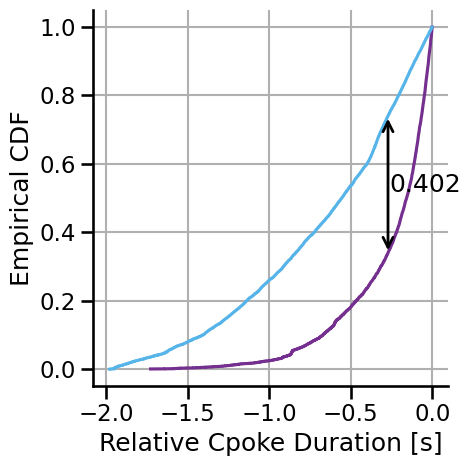

In [54]:
fig, ax = run_and_plot_ks_test(invalid_v1_7_days, invalid_v2_7_days, title="")
ax.legend().remove()

c.save_fig(fig, "fig5_empirical_cdf_growing_pre_go_first_7")

**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.209, p-value: 0.000e+00
Maximum Difference at 0.140s


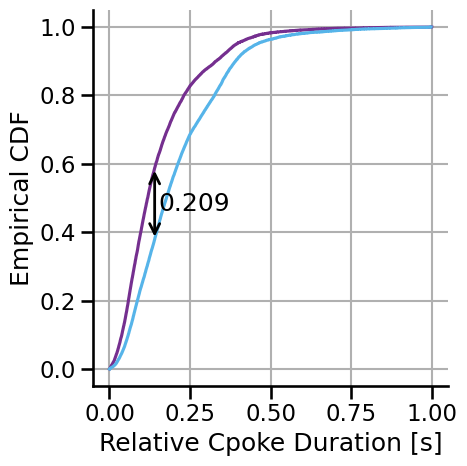

In [55]:
fig, ax = run_and_plot_ks_test(valid_v1_7_days, valid_v2_7_days, title="")
ax.legend().remove()
c.save_fig(fig, "fig5_empirical_cdf_growing_post_go_first_7")


# Supplement 5: V1 Without Warm Up

Warm up trials happen in the first 20 trials after the first day of growth


In [56]:
pdf = u.compute_days_relative_to_stage(pdf, 5)
no_warm_up_df = pdf.query(
    "fix_experiment == 'V1' and stage in @c.GROWING_STAGES and fixation_dur < 2 and days_relative_to_stage_5 > 0 and trial > 20"
)

Violation Duration Stats
N violation cpokes: 14003
Mean Violation Duration: -0.55 +/- 0.46 std
Median Violation Duration: -0.45

Valid Duration Stats
N valid cpokes: 53923
Mean Valid Duration: 0.21 +/- 0.15 std
Median Valid Duration: 0.18


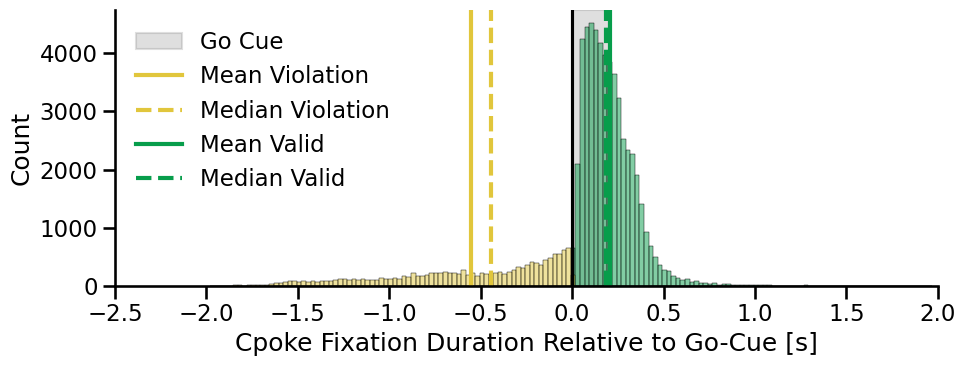

In [58]:
fig, ax = plot_relative_cpoke_dur_histplot(
    no_warm_up_df,
    title="",
    title_color=c.V1_COLOR,
)

c.save_fig(fig, "figs5_V1_poke_histogram_growing_stages_no_warmup")

# fig.savefig("figures/V0_figs5a_V1_histogram_no_warmup.png", dpi=300, bbox_inches="tight")

In [59]:
no_warm_up_stats_df = no_warm_up_df.query(
    "relative_cpoke_dur < 1"
)  # other filters already applied

# Conditions V1
df_v1_no_warm_up = no_warm_up_stats_df[no_warm_up_stats_df["fix_experiment"] == "V1"]
all_v1_no_warm_up = df_v1_no_warm_up["relative_cpoke_dur"].dropna()

In [60]:
# accounted for 0.5% of the maximum difference in V1 vs V2 relative cpoke distributions

In [61]:
print(f"V1 size: {len(all_v1_no_warm_up)}, V2 size: {len(all_v2)}")

V1 size: 67724, V2 size: 46636


**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.225, p-value: 0.000e+00
Maximum Difference at -0.099s


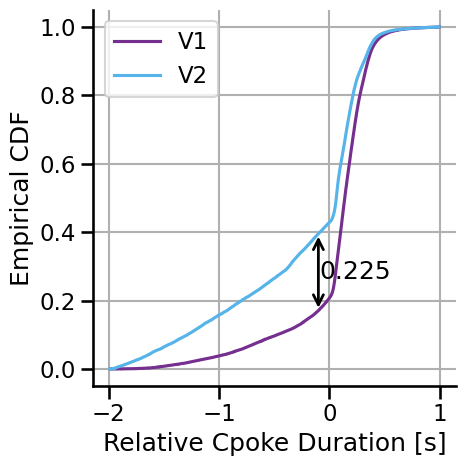

In [63]:
fig, ax = run_and_plot_ks_test(all_v1_no_warm_up, all_v2, title="")

c.save_fig(fig, "fig5_empirical_cdf_growing_pre_and_post_go_no_warmup")

# Supplement 5: V1 & V2 Probe Stages


Violation Duration Stats
N violation cpokes: 1172
Mean Violation Duration: -0.80 +/- 0.44 std
Median Violation Duration: -0.82

Valid Duration Stats
N valid cpokes: 9599
Mean Valid Duration: 0.20 +/- 0.13 std
Median Valid Duration: 0.18


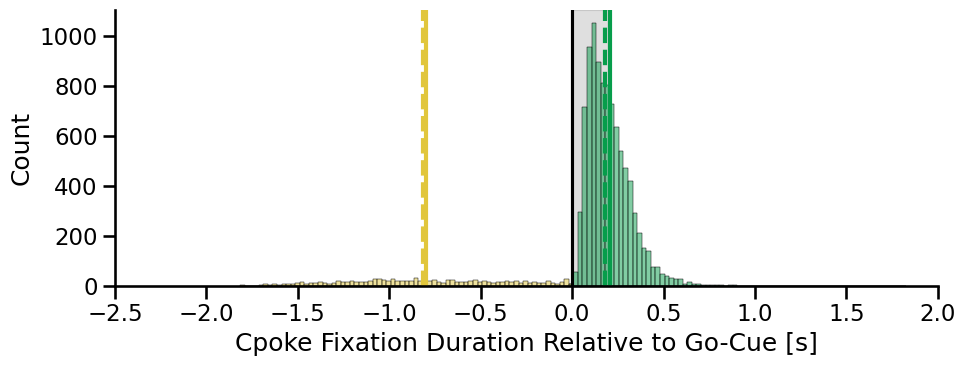

In [67]:
v1_plot_df = pdf.query(
    "fix_experiment == 'V1' and stage in @c.PROBE_STAGES and fixation_dur < 2"
)

fig, ax = plot_relative_cpoke_dur_histplot(
    v1_plot_df,
    title="",
    title_color=c.V1_COLOR,
)

ax.legend().remove()

c.save_fig(fig, "figs5_V1_poke_histogram_probe_stages")


Violation Duration Stats
N violation cpokes: 1181
Mean Violation Duration: -0.86 +/- 0.44 std
Median Violation Duration: -0.89

Valid Duration Stats
N valid cpokes: 11099
Mean Valid Duration: 0.19 +/- 0.13 std
Median Valid Duration: 0.17


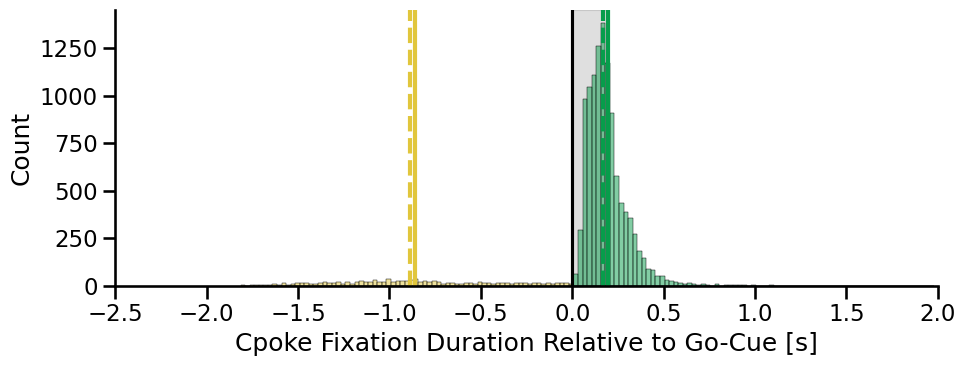

In [68]:
v2_plot_df = pdf.query(
    "fix_experiment == 'V2' and stage in @c.PROBE_STAGES and fixation_dur < 2"
)

fig, ax = plot_relative_cpoke_dur_histplot(
    v2_plot_df,
    title="",
    title_color=c.V2_COLOR,
)

ax.legend().remove()
c.save_fig(fig, "figs5_V2_poke_histogram_probe_stages")


## Statistics for Probe Stages


In [69]:
probe_stats_df = pd.concat([v1_plot_df, v2_plot_df])
probe_stats_df = probe_stats_df.query("relative_cpoke_dur < 1")

# Conditions V1
df_v1_probe = probe_stats_df[probe_stats_df["fix_experiment"] == "V1"]
all_v1_probe = df_v1_probe["relative_cpoke_dur"].dropna()
valid_v1_probe = df_v1_probe[df_v1_probe["was_valid"] == True][
    "relative_cpoke_dur"
].dropna()
invalid_v1 = df_v1[df_v1["was_valid"] == False]["relative_cpoke_dur"].dropna()

# Conditions V2
df_v2_probe = probe_stats_df[probe_stats_df["fix_experiment"] == "V2"]
all_v2_probe = df_v2_probe["relative_cpoke_dur"].dropna()
valid_v2_probe = df_v2_probe[df_v2_probe["was_valid"] == True][
    "relative_cpoke_dur"
].dropna()
invalid_v2_probe = df_v2_probe[df_v2_probe["was_valid"] == False][
    "relative_cpoke_dur"
].dropna()

In [70]:
#size
print(f"V1 size: {len(all_v1_probe)}, V2 size: {len(all_v2_probe)}")

V1 size: 10757, V2 size: 12239


**SIGNIFICANT** V1 and V2 are different
V1 KS statistic: 0.074, p-value: 6.806e-28
Maximum Difference at 0.221s


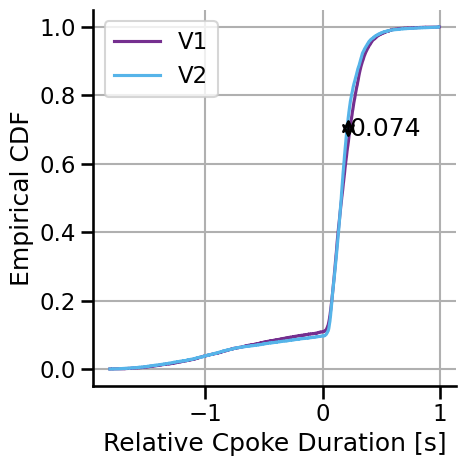

In [72]:
fig, ax = run_and_plot_ks_test(all_v1_probe, all_v2_probe, title="")

c.save_fig(fig, "figs5_empirical_cdf_probe_pre_and_post_go")


# F & G (Over Days)


stopped here- trying to put both on horizontal plot and then want to move the ecdfs down to here


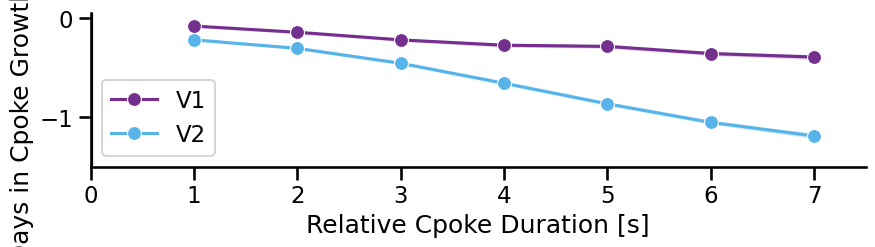

In [ ]:
max_days = 7
pdf["days_in_cpoke_growth"] = pdf["days_relative_to_stage_5"].astype(int) + 1

violation_df  = pdf.query("days_in_cpoke_growth <= @max_days and was_valid == False and stage in @c.GROWING_STAGES")
valid_df  = pdf.query("days_in_cpoke_growth <= @max_days and was_valid == False and stage in @c.GROWING_STAGES")
fig, ax = plt.subplots(figsize=(10, 2))
sns.despine()

ax.axvline(0, color="k", lw=3)
sns.lineplot(data=violation_df, x="days_in_cpoke_growth", y="relative_cpoke_dur",hue="fix_experiment", palette=c.EXP_PALETTE, hue_order=c.HUE_ORDER_EXP, ax=ax, marker="o", markersize=10, errorbar="se")

ax.set(
    xlabel="Relative Cpoke Duration [s]",
    ylabel="N Days in Cpoke Growth Stages",
    xlim=(0, max_days + 0.5),
    ylim=(-1.5, 0.05)
)
ax.legend(title="", loc="lower left")

# res = ttest_cpoke_durations_by_day(plot_df, max_days)
# # Annotate the plot with a '*' at x = -1.4 for each significant day (Bonferroni p_adj < 0.05)
# x_annot = -1.4  # x-value for annotation
# for day, stats in res.items():
#     if stats["p_adj"] < 0.05:
#         # Add a star annotation at the given x coordinate and the day's y coordinate
#         ax.text(x_annot, day, "***", fontsize=10, color="k", va="center", ha="center", fontweight="bold")


# fig.savefig("figures/V0_fig5_violation_cpoke_over_days.png", dpi=300, bbox_inches="tight")


V1 size: 1094, V2 size: 2010
Day 1: **SIGNIFICANT**
t = 43.597, p = 0.000e+00, Bonferroni adj p = 0.000e+00
V1 size: 876, V2 size: 1847
Day 2: **SIGNIFICANT**
t = 28.971, p = 3.069e-157, Bonferroni adj p = 2.149e-156
V1 size: 906, V2 size: 1949
Day 3: **SIGNIFICANT**
t = 29.223, p = 5.801e-162, Bonferroni adj p = 4.061e-161
V1 size: 617, V2 size: 1943
Day 4: **SIGNIFICANT**
t = 32.088, p = 9.141e-175, Bonferroni adj p = 6.399e-174
V1 size: 731, V2 size: 2105
Day 5: **SIGNIFICANT**
t = 44.500, p = 4.658e-314, Bonferroni adj p = 3.261e-313
V1 size: 653, V2 size: 2302
Day 6: **SIGNIFICANT**
t = 45.884, p = 1.700e-321, Bonferroni adj p = 1.190e-320
V1 size: 732, V2 size: 1330
Day 7: **SIGNIFICANT**
t = 37.904, p = 5.647e-239, Bonferroni adj p = 3.953e-238


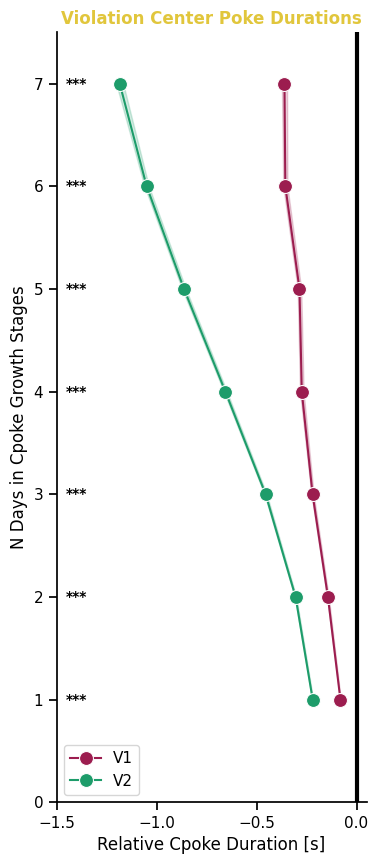

In [87]:
max_days = 7
pdf["days_in_cpoke_growth"] = pdf["days_relative_to_stage_5"].astype(int) + 1

plot_df  = pdf.query("days_in_cpoke_growth <= @max_days and was_valid == False and stage in @c.GROWING_STAGES")

fig, ax = plt.subplots(figsize=(4, 10))
sns.despine()

ax.axvline(0, color="k", lw=3)
sns.lineplot(data=plot_df, y="days_in_cpoke_growth", x="relative_cpoke_dur", orient="y",hue="fix_experiment", palette=c.EXP_PALETTE, hue_order=c.HUE_ORDER_EXP, ax=ax, marker="o", markersize=10, errorbar="se")

ax.set(
    xlabel="Relative Cpoke Duration [s]",
    ylabel="N Days in Cpoke Growth Stages",
    ylim=(0, max_days + 0.5),
    xlim=(-1.5, 0.05)
)
ax.set_title("Violation Center Poke Durations", fontweight="bold", color=c.VALID_PALETTE[0])
ax.legend(title="", loc="lower left")

res = ttest_cpoke_durations_by_day(plot_df, max_days)
# Annotate the plot with a '*' at x = -1.4 for each significant day (Bonferroni p_adj < 0.05)
x_annot = -1.4  # x-value for annotation
for day, stats in res.items():
    if stats["p_adj"] < 0.05:
        # Add a star annotation at the given x coordinate and the day's y coordinate
        ax.text(x_annot, day, "***", fontsize=10, color="k", va="center", ha="center", fontweight="bold")


fig.savefig("figures/V0_fig5_violation_cpoke_over_days.png", dpi=300, bbox_inches="tight")


V1 size: 2371, V2 size: 2651
Day 1: **SIGNIFICANT**
t = -21.795, p = 2.795e-100, Bonferroni adj p = 1.957e-99
V1 size: 2073, V2 size: 2783
Day 2: **SIGNIFICANT**
t = -22.549, p = 3.757e-106, Bonferroni adj p = 2.630e-105
V1 size: 2104, V2 size: 2714
Day 3: **SIGNIFICANT**
t = -20.818, p = 4.007e-92, Bonferroni adj p = 2.805e-91
V1 size: 1780, V2 size: 2301
Day 4: **SIGNIFICANT**
t = -12.656, p = 5.822e-36, Bonferroni adj p = 4.075e-35
V1 size: 2442, V2 size: 2581
Day 5: **SIGNIFICANT**
t = -11.765, p = 2.187e-31, Bonferroni adj p = 1.531e-30
V1 size: 2575, V2 size: 2572
Day 6: **SIGNIFICANT**
t = -12.639, p = 9.608e-36, Bonferroni adj p = 6.726e-35
V1 size: 2301, V2 size: 2040
Day 7: **SIGNIFICANT**
t = -7.214, p = 7.002e-13, Bonferroni adj p = 4.902e-12


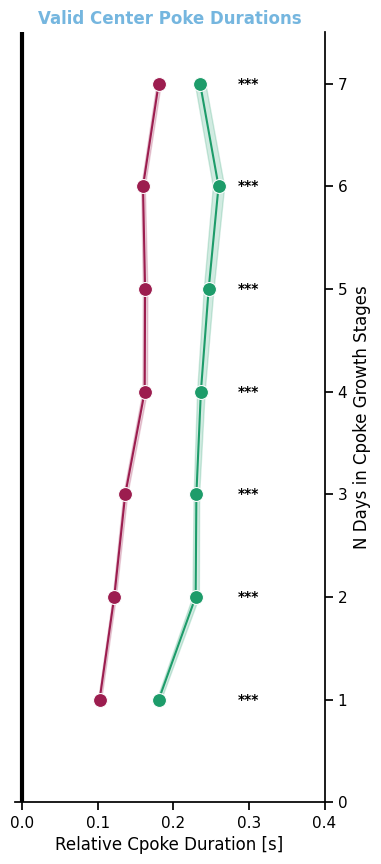

In [88]:
max_days = 7
pdf["days_in_cpoke_growth"] = pdf["days_relative_to_stage_5"].astype(int) + 1

plot_df  = pdf.query("days_in_cpoke_growth <= @max_days and was_valid == True and stage in @c.GROWING_STAGES")

fig, ax = plt.subplots(figsize=(4, 10))
sns.despine(top=True, right=False, left=True)

ax.axvline(0, color="k", lw=3)
sns.lineplot(data=plot_df, y="days_in_cpoke_growth", x="relative_cpoke_dur", orient="y",hue="fix_experiment", palette=c.EXP_PALETTE, hue_order=c.HUE_ORDER_EXP, ax=ax, marker="o", markersize=10, errorbar="se")

ax.set(
    xlabel="Relative Cpoke Duration [s]",
    ylabel="N Days in Cpoke Growth Stages",
    ylim=(0, max_days + 0.5 ),
    xlim=(-0.01, 0.4)
)

ax.set_title("Valid Center Poke Durations", fontweight="bold", color=c.VALID_PALETTE[1])
ax.yaxis.tick_right()  
ax.yaxis.set_label_position('right')
ax.legend().remove()


res = ttest_cpoke_durations_by_day(plot_df, max_days)
x_annot = 0.3  # x-value for annotation
for day, stats in res.items():
    if stats["p_adj"] < 0.05:
        # Add a star annotation at the given x coordinate and the day's y coordinate
        ax.text(x_annot, day, "***", fontsize=10, color="k", va="center", ha="center", fontweight="bold")

#save the figure
fig.savefig("figures/V0_fig5_valid_cpoke_over_days.png", dpi=300, bbox_inches="tight")

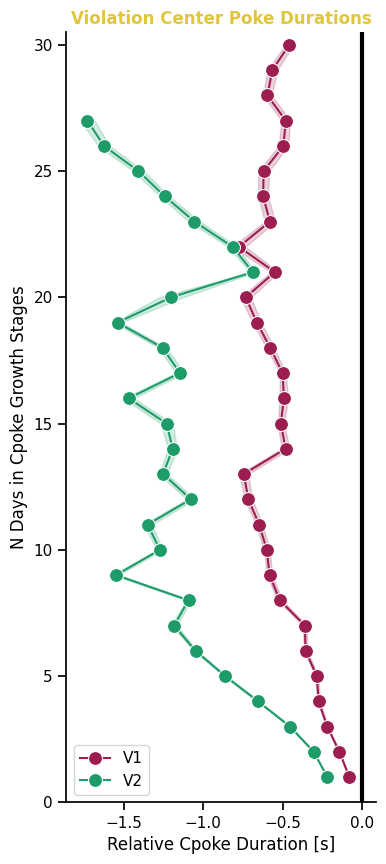

In [83]:
max_days = 30
pdf["days_in_cpoke_growth"] = pdf["days_relative_to_stage_5"].astype(int) + 1

plot_df  = pdf.query("days_in_cpoke_growth <= @max_days and was_valid == False and stage in @c.GROWING_STAGES and relative_cpoke_dur > -2.5")

fig, ax = plt.subplots(figsize=(4, 10), dpi=100)
sns.despine()

ax.axvline(0, color="k", lw=3)
sns.lineplot(data=plot_df, y="days_in_cpoke_growth", x="relative_cpoke_dur", orient="y",hue="fix_experiment", palette=c.EXP_PALETTE, hue_order=c.HUE_ORDER_EXP, ax=ax, marker="o", markersize=10, errorbar="se")

ax.set(
    xlabel="Relative Cpoke Duration [s]",
    ylabel="N Days in Cpoke Growth Stages",
    ylim=(0, max_days + 0.5),
    # xlim=(-1.5, 0.05)
)
ax.set_title("Violation Center Poke Durations", fontweight="bold", color=c.VALID_PALETTE[0])
ax.legend(title="", loc="lower left")

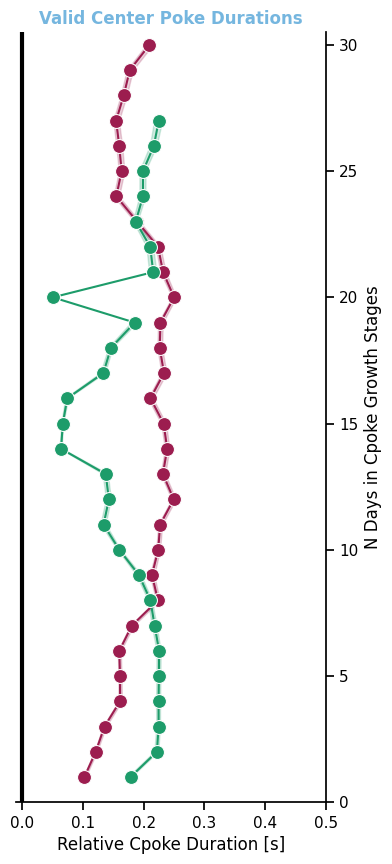

In [84]:
max_days = 30
pdf["days_in_cpoke_growth"] = pdf["days_relative_to_stage_5"].astype(int) + 1

plot_df  = pdf.query("days_in_cpoke_growth <= @max_days and was_valid == True and stage in @c.GROWING_STAGES and relative_cpoke_dur < 1.5")

fig, ax = plt.subplots(figsize=(4, 10), dpi=100)
sns.despine(top=True, right=False, left=True)

ax.axvline(0, color="k", lw=3)
sns.lineplot(data=plot_df, y="days_in_cpoke_growth", x="relative_cpoke_dur", orient="y",hue="fix_experiment", palette=c.EXP_PALETTE, hue_order=c.HUE_ORDER_EXP, ax=ax, marker="o", markersize=10, errorbar="se")

ax.set(
    xlabel="Relative Cpoke Duration [s]",
    ylabel="N Days in Cpoke Growth Stages",
    ylim=(0, max_days + 0.5 ),
    xlim=(-0.01, 0.5)
)

ax.set_title("Valid Center Poke Durations", fontweight="bold", color=c.VALID_PALETTE[1])
ax.yaxis.tick_right()  
ax.yaxis.set_label_position('right')
ax.legend().remove()